<a href="https://colab.research.google.com/github/sergekamanzi/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries and Download NLTK Resources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Dataset and Check for Missing Values

In [4]:
# Load dataset from local file (ensure 'IMDB Dataset.csv' is uploaded to /content/ in Colab)
data = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Verify dataset columns
print("Dataset Columns:", data.columns)

# Check for missing values
missing_values = data.isnull().sum()
missing_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})
print("\nMissing Values:")
print(missing_df)

# Handle missing values
data['review'] = data['review'].fillna('')
data = data.dropna(subset=['sentiment'])

Dataset Columns: Index(['review', 'sentiment'], dtype='object')

Missing Values:
      Column  Missing Values
0     review               0
1  sentiment               0


# Data Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply text cleaning
data['cleaned_review'] = data['review'].apply(clean_text)

# Convert sentiment labels to binary (positive=1, negative=0)
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Verify sentiment conversion
print("\nSentiment Value Counts:")
print(data['sentiment'].value_counts())


Sentiment Value Counts:
sentiment
1    25000
0    25000
Name: count, dtype: int64


# Data Visualization

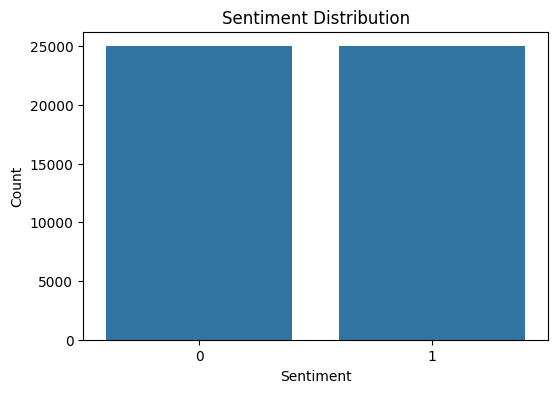

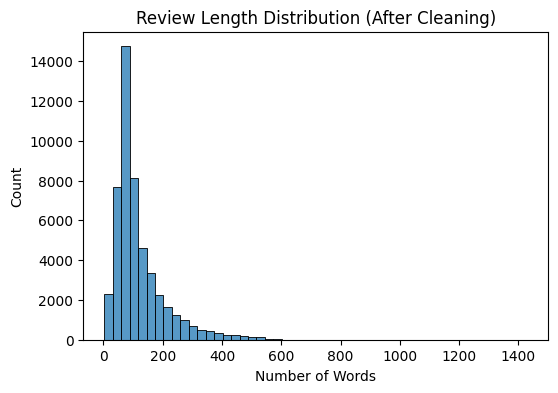

In [7]:
# Visualization - Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualization - Review Length Distribution
data['review_length'] = data['cleaned_review'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(6,4))
sns.histplot(data['review_length'], bins=50)
plt.title('Review Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Data Splitting and TF-IDF Vectorization

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
max_features = 5000
tfidf = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression Model (MODEL1 )

In [9]:
lr_results = []
C_values = [0.01, 0.1, 1.0]
solvers = ['liblinear', 'lbfgs']

for C in C_values:
    for solver in solvers:
        model_lr = LogisticRegression(C=C, solver=solver, max_iter=1000)
        model_lr.fit(X_train_tfidf, y_train)
        y_pred = model_lr.predict(X_test_tfidf)
        lr_results.append({
            'C': C,
            'Solver': solver,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred)
        })

# Display Logistic Regression results
lr_results_df = pd.DataFrame(lr_results)
print("\nLogistic Regression Experiment Results:")
print(lr_results_df)
lr_results_df.to_csv('/content/lr_results.csv', index=False)

# Train final Logistic Regression model (best parameters: C=1.0, solver='liblinear')
model_lr = LogisticRegression(C=1.0, solver='liblinear', max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)
print("\nFinal Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")



Logistic Regression Experiment Results:
      C     Solver  Accuracy  Precision    Recall  F1-Score
0  0.01  liblinear    0.8346   0.816533  0.866442  0.840747
1  0.01      lbfgs    0.8341   0.815534  0.866839  0.840404
2  0.10  liblinear    0.8714   0.856410  0.894820  0.875194
3  0.10      lbfgs    0.8711   0.855923  0.894820  0.874939
4  1.00  liblinear    0.8864   0.877978  0.899583  0.888649
5  1.00      lbfgs    0.8865   0.877855  0.899980  0.888780

Final Logistic Regression Metrics:
Accuracy: 0.8864
Precision: 0.8780
Recall: 0.8996
F1-Score: 0.8886


# Logistic Regression Visualizations

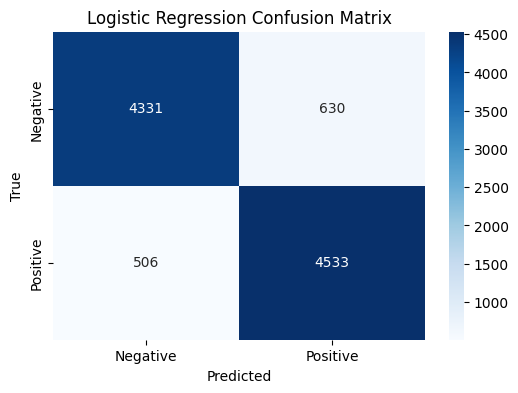

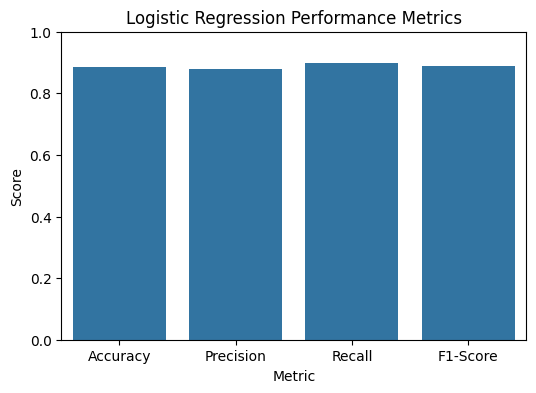

In [10]:
# Visualization: Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualization: Performance Metrics Bar Plot
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr)
    ]
})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Logistic Regression Performance Metrics')
plt.ylim(0, 1)
plt.show()

# LSTM Model Preparation(MODEL 2)

In [13]:
# TF-IDF features for LSTM
max_len = 200
def truncate_or_pad_features(features, max_len):
    if features.shape[1] > max_len:
        return features[:, :max_len]
    elif features.shape[1] < max_len:
        return np.pad(features, ((0, 0), (0, max_len - features.shape[1])), mode='constant')
    return features

X_tfidf = tfidf.fit_transform(data['cleaned_review']).toarray()
X_tfidf = truncate_or_pad_features(X_tfidf, max_len)
y = data['sentiment'].values

# Split data for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Cell 10: LSTM Model Training and Evaluation
# LSTM Model
model_lstm = Sequential([
    LSTM(128, input_shape=(max_len, 1), return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)

# Print scores
print("\nLSTM with TF-IDF Metrics:")
print(f"Accuracy: {accuracy_score(y_test_lstm, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_test_lstm, y_pred_lstm, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test_lstm, y_pred_lstm, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test_lstm, y_pred_lstm, zero_division=0):.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 271s 535ms/step - accuracy: 0.5050 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 334s 559ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 322s 558ms/step - accuracy: 0.4985 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 319s 552ms/step - accuracy: 0.4929 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 323s 555ms/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 323s 556ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 320s 552ms/step - accuracy: 0.4944 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 328s 565ms/step - accuracy: 0.5041 -

# LSTM Visualizations

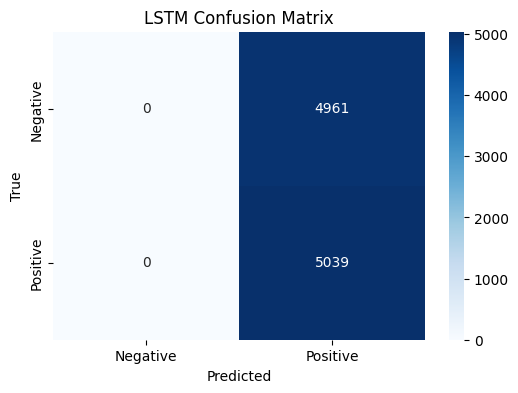

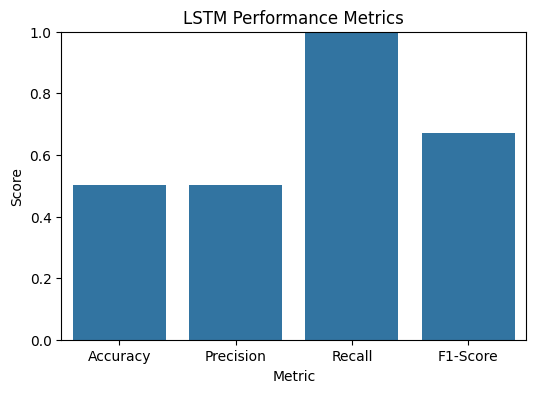

In [14]:
# Visualization: Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Visualization: Performance Metrics Bar Plot for LSTM
metrics_df_lstm = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_test_lstm, y_pred_lstm),
        precision_score(y_test_lstm, y_pred_lstm, zero_division=0),
        recall_score(y_test_lstm, y_pred_lstm, zero_division=0),
        f1_score(y_test_lstm, y_pred_lstm, zero_division=0)
    ]
})
plt.figure(figsize=(6,4))
sns.barplot(x='Metric', y='Score', data=metrics_df_lstm)
plt.title('LSTM Performance Metrics')
plt.ylim(0, 1)
plt.show()